![ine-divider](https://user-images.githubusercontent.com/7065401/92672068-398e8080-f2ee-11ea-82d6-ad53f7feb5c0.png)
<hr>

### Secure RESTful APIs using Python

# More refactoring to micro-services

For this project, we use a version of the small `fractal` package that is used in a number of other INE courses.  We would like to provide all of these capabilities as a collection of small servers that might operate independently, each potentially running on different nodes of a cluster.  All the code is in files within the `fractal/` subdirectory.

![orange-divider](https://user-images.githubusercontent.com/7065401/92672455-187a5f80-f2ef-11ea-890c-40be9474f7b7.png)

## Part 1

**Communicating arrays**

In the project for the last lesson, you created routes that would generate fractals as PNG images.  In that case, what you were asked to do was a simiplification of the structure of the library.  Specifically, what the library really generates are **NumPy arrays** that represent fractals; the visualization is an optional secondary step.  You were not aked to do that to skip the need for transmitting data in formats other than as a PNG image.

However, a microservice architecture should not do everything at one route.  Rendering is separate from generation, and moreover, you'd like to be able to work with the numeric arrays directly at times.  One note, however, is that rendering each single complex point on a separate node/service is going to be hugely inefficient.  The appropriate level of granularity is the "canvas" (i.e. 2-D integer array of points that is potentially visualized).

In [1]:
from fractal.julia import julia
julia

<function fractal.julia.julia(z: complex, c: complex = (-0.1+0.65j), orbits: int = 255) -> int>

In [2]:
from fractal.visualize import make_canvas, visualize
make_canvas

<function fractal.visualize.make_canvas(fn: collections.abc.Callable, x: float, y: float, size: float, pixels: int, kws: dict = {}) -> numpy.ndarray>

In [3]:
canvas = make_canvas(julia, -0.85, 0.5, 1, 400)
canvas

array([[ 2,  2,  2, ..., 82, 81, 81],
       [ 2,  2,  2, ..., 81, 81, 81],
       [ 2,  2,  2, ..., 81, 81, 81],
       ...,
       [ 1,  1,  1, ...,  4,  4,  4],
       [ 1,  1,  1, ...,  4,  4,  4],
       [ 1,  1,  1, ...,  4,  4,  4]], dtype=uint8)

For this task, create a service `solution1.py` that has a route `/julia` which will take the parameters necessary to return an integer array.  Rendering to a graphic format is left to the next task, at this step you only care about generating the fractal in the first place.

**A possible solution**

A server like the following will support the requirement.  For this service, we have decided to return the data as JSON.  This potentially allows utilization of the "fractal arrays" by languages other than Python, or by libraries other than NumPy.

Launch it with, e.g.:

```bash
FLASK_APP=solution1.py flask run --port 5012
```

In [4]:
# %load solution1.py
from matplotlib import pyplot as plt
from fractal.julia import julia
from fractal.visualize import make_canvas
from flask import Flask, request, jsonify, request
app = Flask(__name__)

@app.route('/julia')
def _julia():
    pixels = int(request.args.get('pixels', 400))
    # touch-up URL encoding for complex given
    c = complex(request.args.get('c', "-0.1+0.65j").replace(' ', '+'))
    x = float(request.args['x'])
    y = float(request.args['y'])
    size = float(request.args['size'])
    canvas = make_canvas(julia, x, y, size, pixels, kws={'c': c})
    return jsonify(canvas.tolist())


In [5]:
import numpy as np
import json
import requests
resp = requests.get('http://localhost:5012/julia?c=-.2+0.7j&x=-0.75&y=0.5&size=1')
arr = np.array(json.loads(resp.text))
arr

array([[  2,   2,   2, ..., 255, 255, 255],
       [  2,   2,   2, ..., 255, 255, 255],
       [  2,   2,   2, ..., 255, 255, 255],
       ...,
       [  2,   2,   2, ...,   4,   4,   4],
       [  2,   2,   2, ...,   4,   4,   4],
       [  2,   2,   2, ...,   4,   4,   4]])

![orange-divider](https://user-images.githubusercontent.com/7065401/92672455-187a5f80-f2ef-11ea-890c-40be9474f7b7.png)

## Part 2

**Visualizing arrays**

By using a common format like JSON to communicate arrays, this potentially allows canvases created by other means to take advantage of a `/visualize` route on a micro-service.  For this task, you wish to accept a JSON request body of the following form and return a rendered image:

```
{"format": "tiff", "arr": [[1, 2, 3], [4, 5, 6], [7, 8, 9]]}
```

Your service should be able to return any of PNG, TIFF, or GIF, as requested.

**A possible solution**

Making as many tries as exponential backoff requires can take a while.  This is a kind of test you would run once at the start of an ongoing utilization of a service, retaining the wait timeout for a relatively long time before checking again.

A server like the following will support the requirement.  Launch it with, e.g.:

```bash
FLASK_APP=solution2.py flask run --port 5013
```

In [6]:
# %load solution2.py
from tempfile import NamedTemporaryFile
import json
from matplotlib import pyplot as plt
from flask import Flask, request, send_file
app = Flask(__name__)

@app.route('/visualize', methods=["POST"])
def visualize():
    data = json.loads(request.data)
    fmt = data.get('format', 'png')
    canvas = data.get('arr', [[0]])

    with NamedTemporaryFile() as imgfile:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(canvas)
        plt.savefig(imgfile)
        imgfile.flush()
        return send_file(imgfile.name, mimetype=f'image/{fmt}')

image/gif


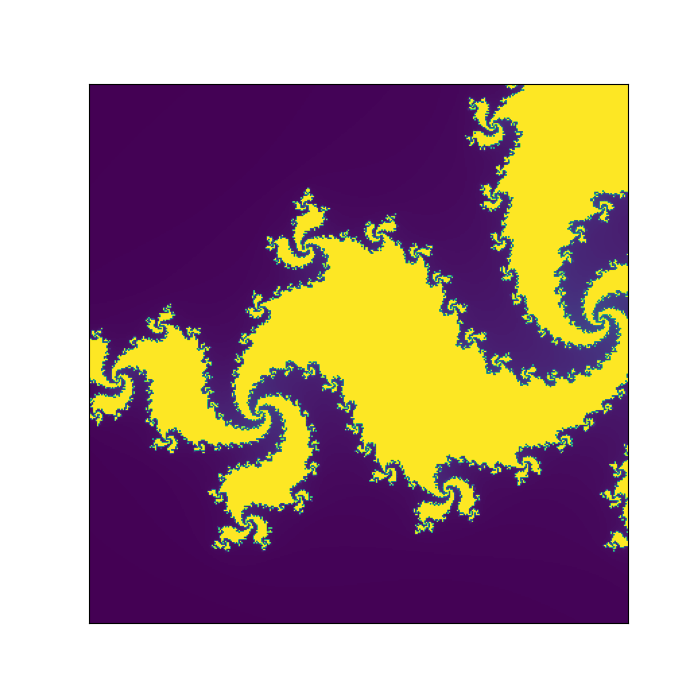

In [7]:
from IPython.display import Image, display
resp = requests.post('http://localhost:5013/visualize', 
                     data=json.dumps({'format': 'gif', 'arr': arr.tolist()}))

print(resp.headers['Content-Type'])
display(Image(resp.content, width=400))

![orange-divider](https://user-images.githubusercontent.com/7065401/92672455-187a5f80-f2ef-11ea-890c-40be9474f7b7.png)